### Simple CNNs and transfer learning for our own very small binary dataset
with 15 images per class (30 total)

In [6]:
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

In [2]:
folder_path = './big_datasets/test_binary_dataset'

In [3]:
import pathlib

In [7]:
train_path = folder_path + '/' + 'train'
test_path = folder_path + '/' + 'test'
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [8]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
list(class_names)

['beer', 'wine']

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory = train_path,
                                               batch_size = 10,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                              )
test_data = test_datagen.flow_from_directory(directory = test_path,
                                               batch_size = 10,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                              )

Found 24 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


#### Simple conv model

In [11]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation="softmax") # classification/prob activation output
])

In [12]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [13]:
history_1 = model_1.fit(train_data, epochs=5,
            steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps = len(test_data))

Epoch 1/5


3/3 [==============================] - 1s 202ms/step - loss: 0.8277 - accuracy: 0.4583 - val_loss: 0.9595 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 0s 66ms/step - loss: 0.6021 - accuracy: 0.7083 - val_loss: 0.6810 - val_accuracy: 0.5000
Epoch 3/5
3/3 [==============================] - 0s 60ms/step - loss: 0.5310 - accuracy: 0.5417 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 0s 81ms/step - loss: 0.4619 - accuracy: 0.8750 - val_loss: 0.6775 - val_accuracy: 0.5000
Epoch 5/5
3/3 [==============================] - 0s 80ms/step - loss: 0.3328 - accuracy: 0.9583 - val_loss: 0.6666 - val_accuracy: 0.6667


In [14]:
def get_history_plots(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(10,7))
    history_df.loc[:, ['loss', 'accuracy']].plot()
    plt.figure(figsize=(10,7))
    history_df.loc[:, ['val_loss', 'val_accuracy']].plot()

<Figure size 1000x700 with 0 Axes>

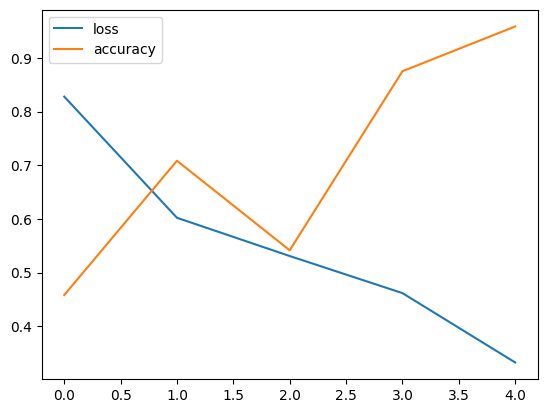

<Figure size 1000x700 with 0 Axes>

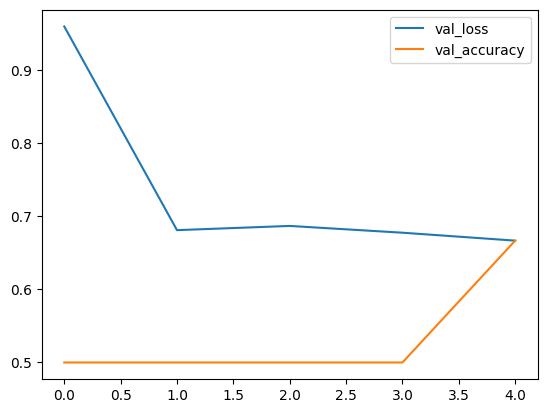

In [15]:
get_history_plots(history_1)

In [16]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [17]:
test_beer = load_and_prep_image('test_beer.jpg')

In [18]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 78ms/step


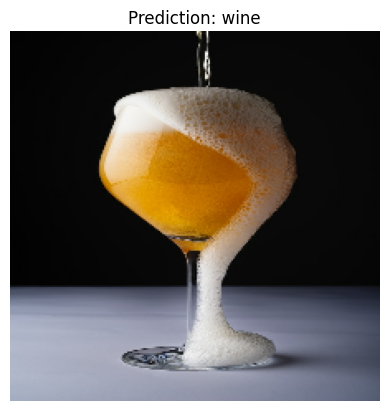

In [19]:
pred_and_plot(model_1, "test_beer.jpg", class_names)

1/1 [==============================] - 0s 17ms/step


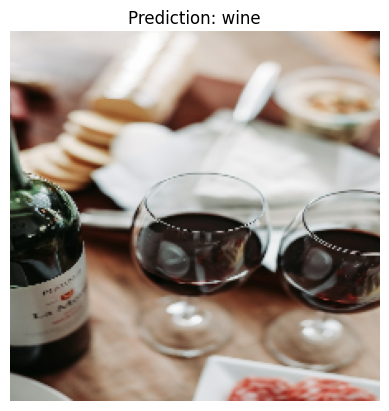

In [20]:
pred_and_plot(model_1, "test_wine.jpg", class_names)

### Efficientnet transfer learning on feature extractor

In [26]:
from tensorflow.keras import layers
import tensorflow_hub as hub

In [24]:
IMAGE_SHAPE = (224,224)

In [22]:
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [28]:
# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                       trainable=False, # freeze the underlying patterns
                                       name='feature_extraction_layer',
                                       input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

In [30]:
num_classes = len(class_names)

In [42]:
# Create our own model
model_2 = tf.keras.Sequential([
feature_extractor_layer, # use the feature extraction layer as the base
layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
])

In [43]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=['accuracy',])

In [44]:
# Fit the model
model_2_history = model_2.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  ) # name of log files

Epoch 1/5
3/3 [==============================] - 2s 383ms/step - loss: 0.9558 - accuracy: 0.3333 - val_loss: 0.7716 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 0s 100ms/step - loss: 0.7103 - accuracy: 0.5833 - val_loss: 0.6753 - val_accuracy: 0.5000
Epoch 3/5
3/3 [==============================] - 0s 115ms/step - loss: 0.5459 - accuracy: 0.6667 - val_loss: 0.5878 - val_accuracy: 0.6667
Epoch 4/5
3/3 [==============================] - 0s 101ms/step - loss: 0.4520 - accuracy: 0.8333 - val_loss: 0.5087 - val_accuracy: 0.8333
Epoch 5/5
3/3 [==============================] - 0s 132ms/step - loss: 0.3474 - accuracy: 0.9583 - val_loss: 0.4371 - val_accuracy: 1.0000


In [36]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 5921874 (22.59 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [37]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

<Figure size 1000x700 with 0 Axes>

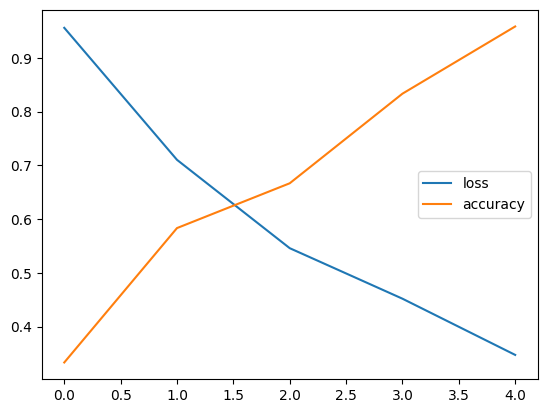

<Figure size 1000x700 with 0 Axes>

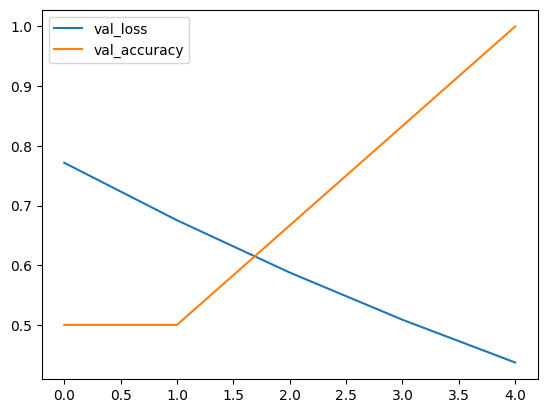

In [45]:
get_history_plots(model_2_history)

1/1 [==============================] - 1s 513ms/step


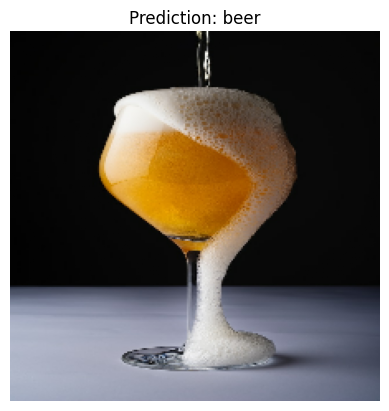

In [48]:
pred_and_plot(model_2, "test_beer.jpg", class_names)

1/1 [==============================] - 0s 39ms/step


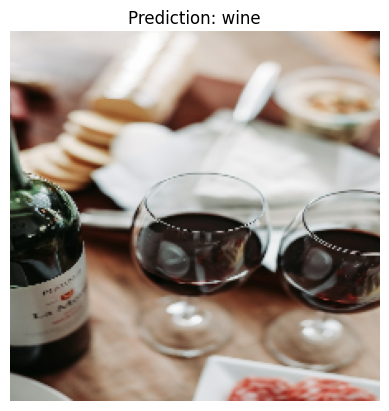

In [49]:
pred_and_plot(model_2, "test_wine.jpg", class_names)